# Import required Libraries

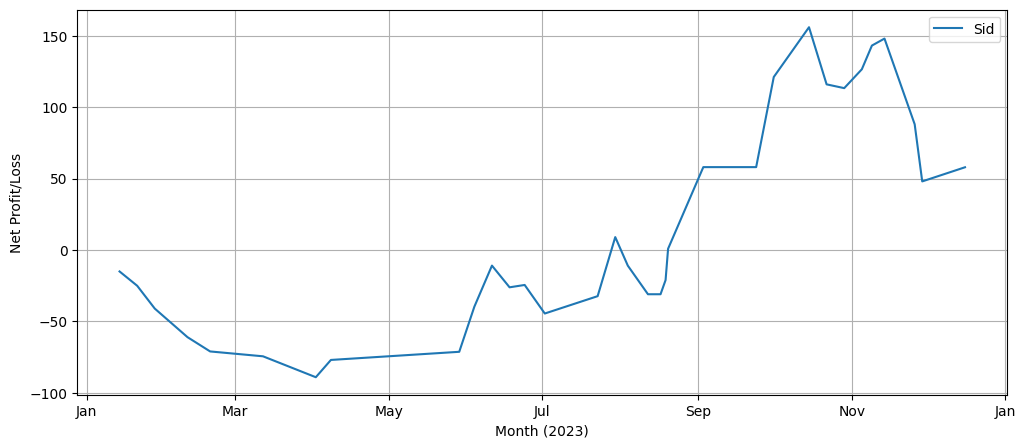

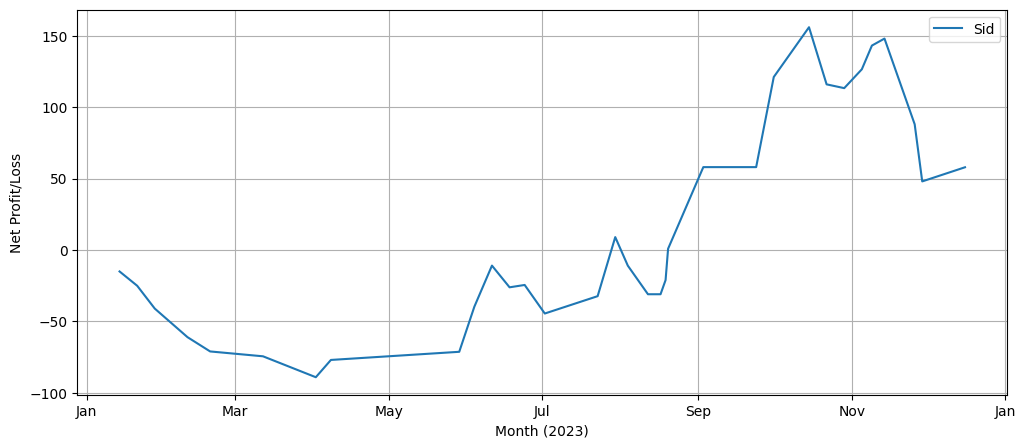

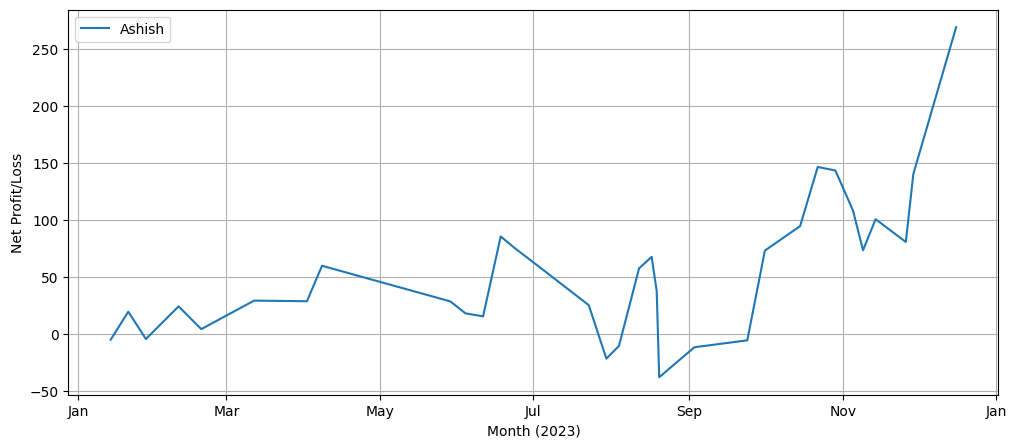

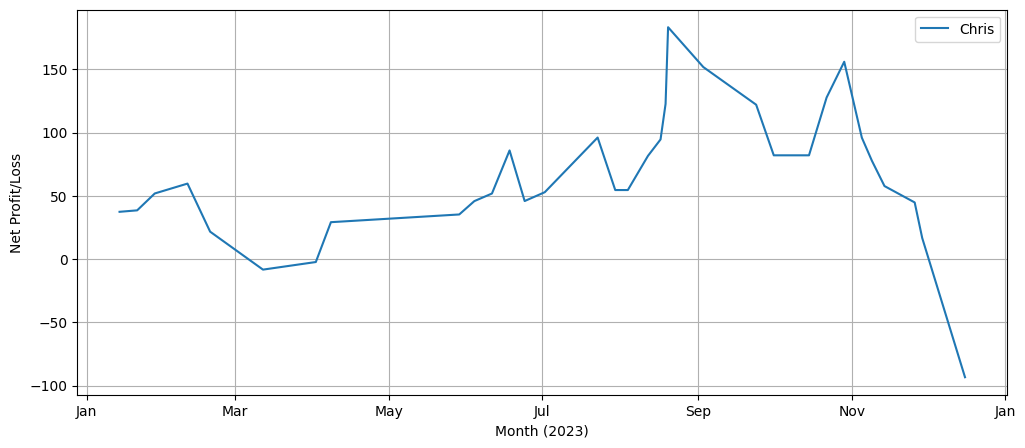

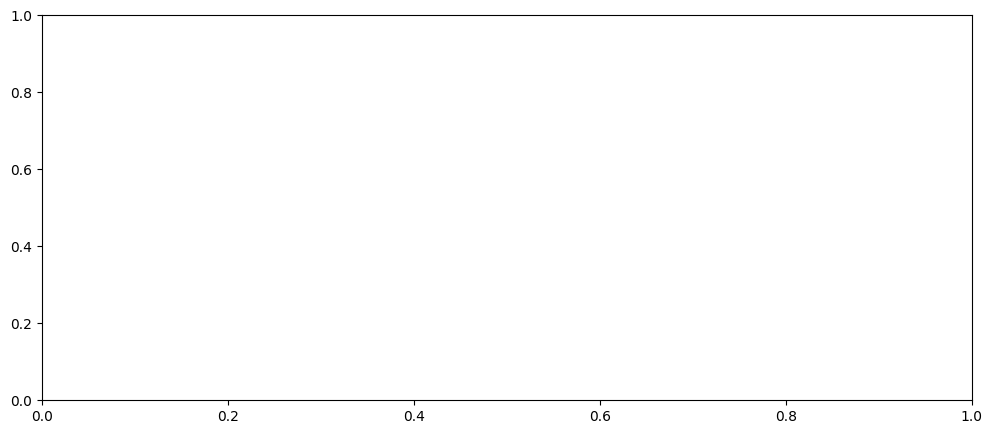

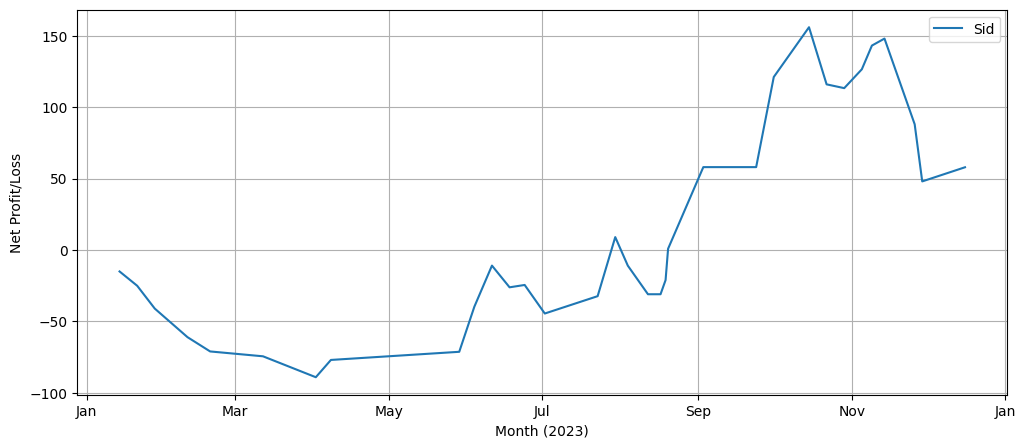

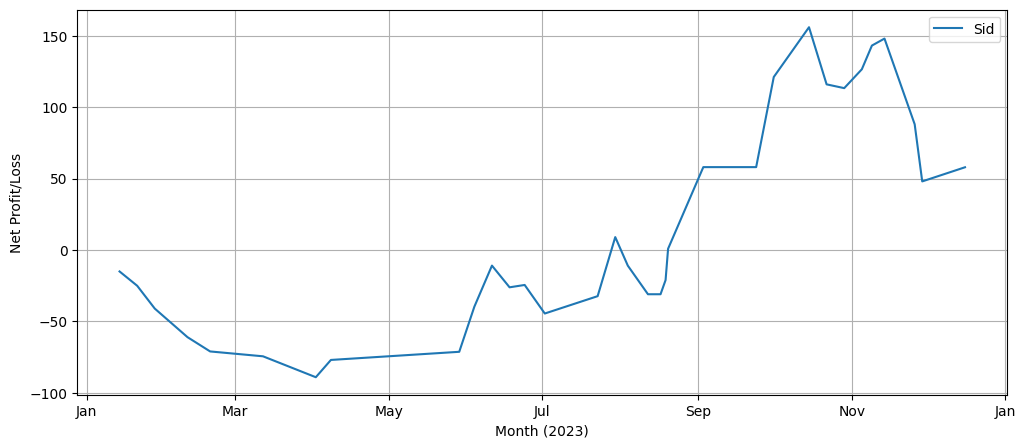

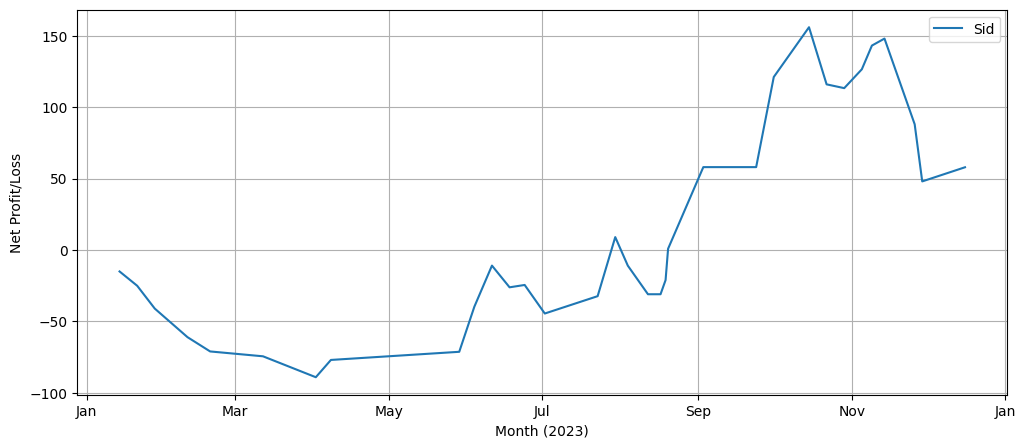

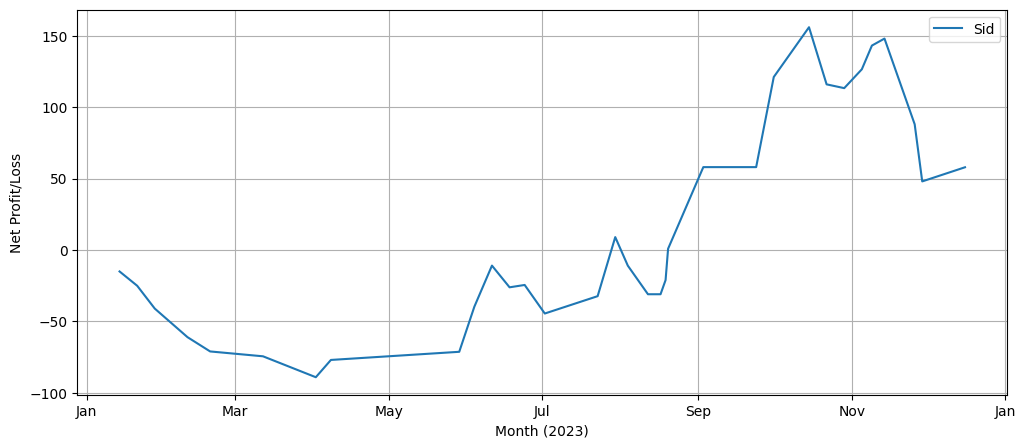

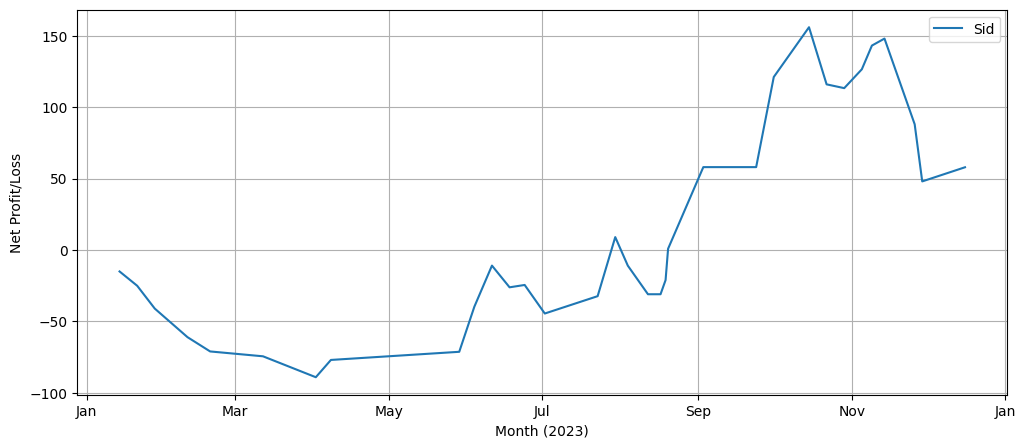

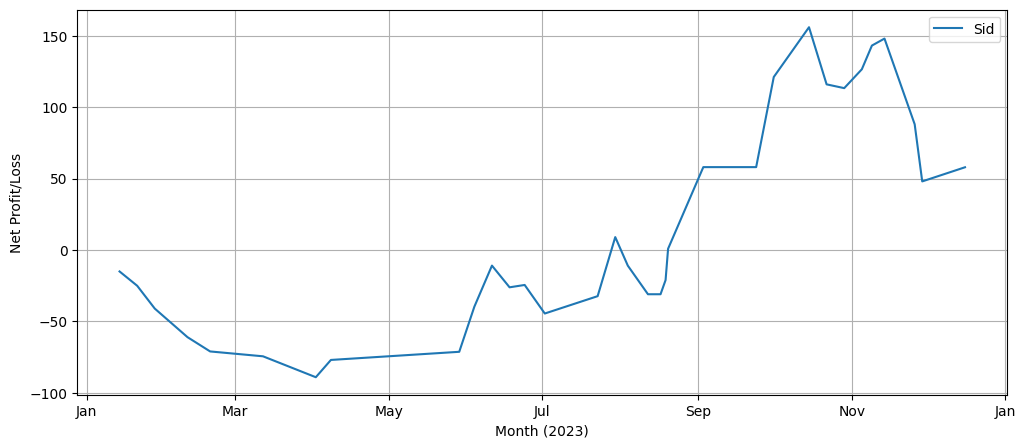

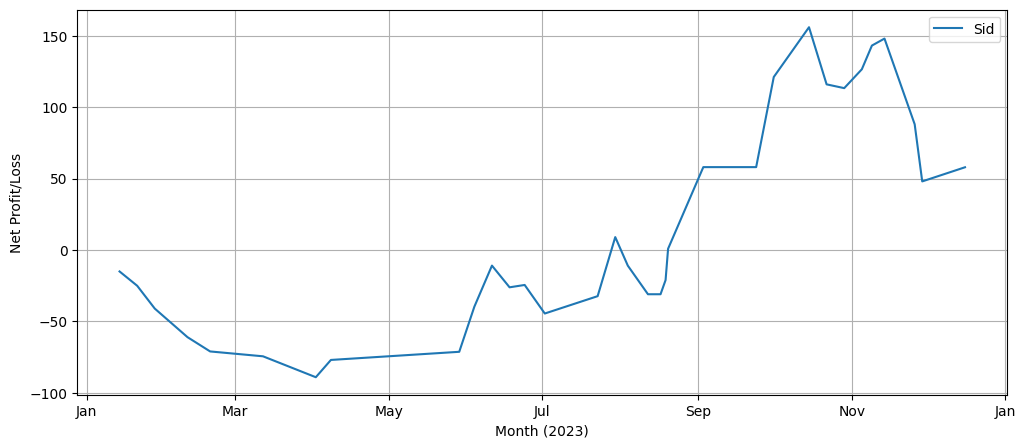

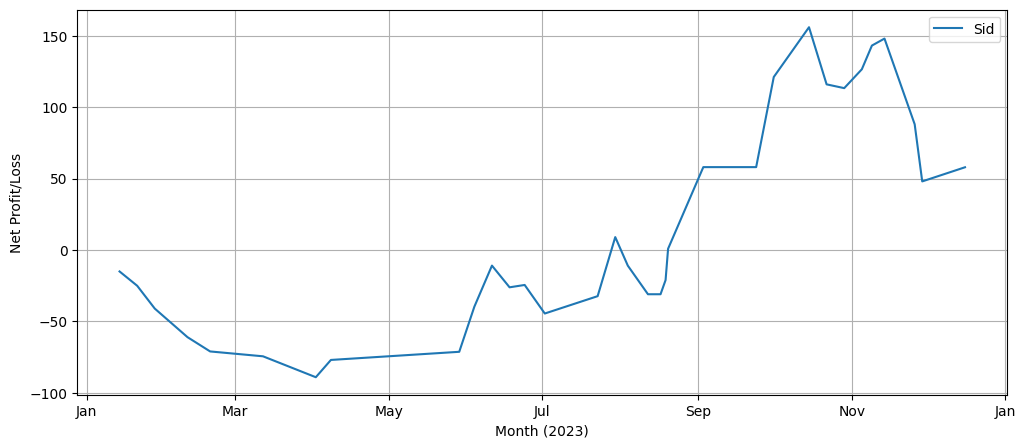

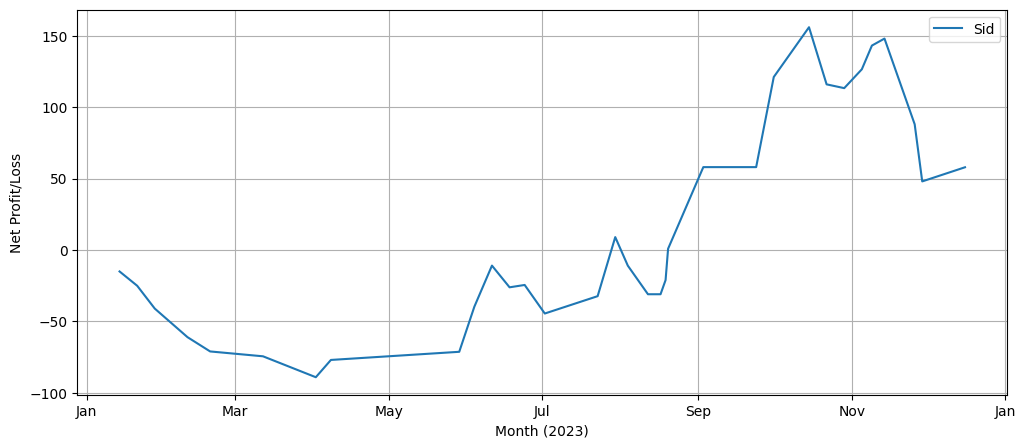

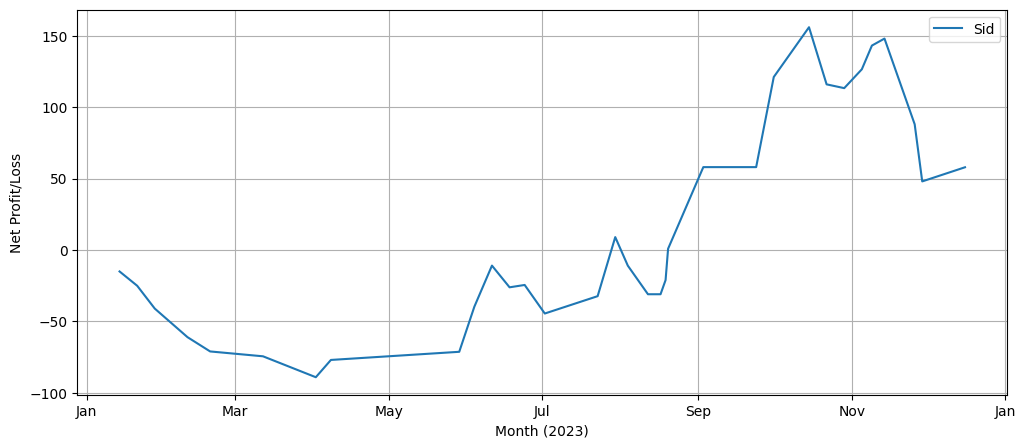

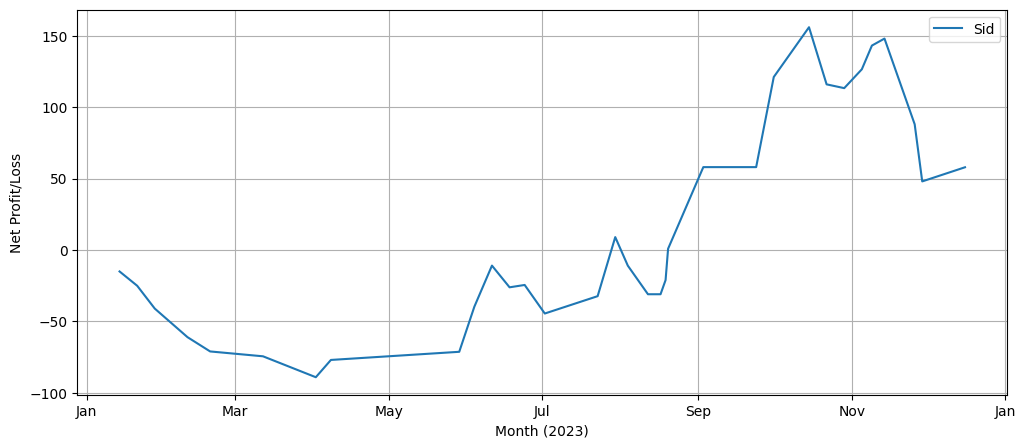

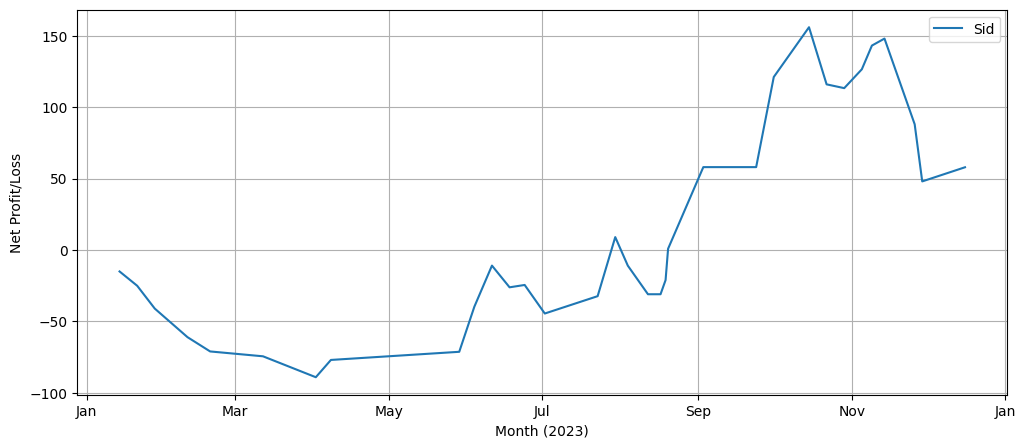

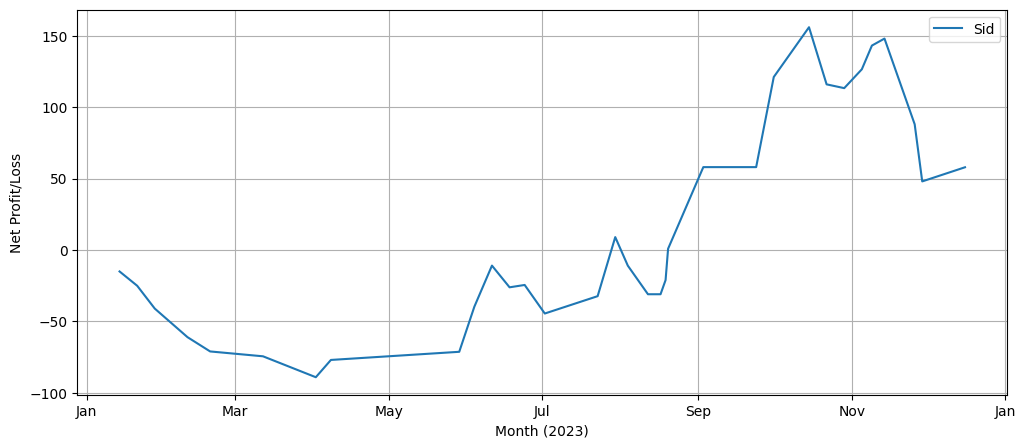

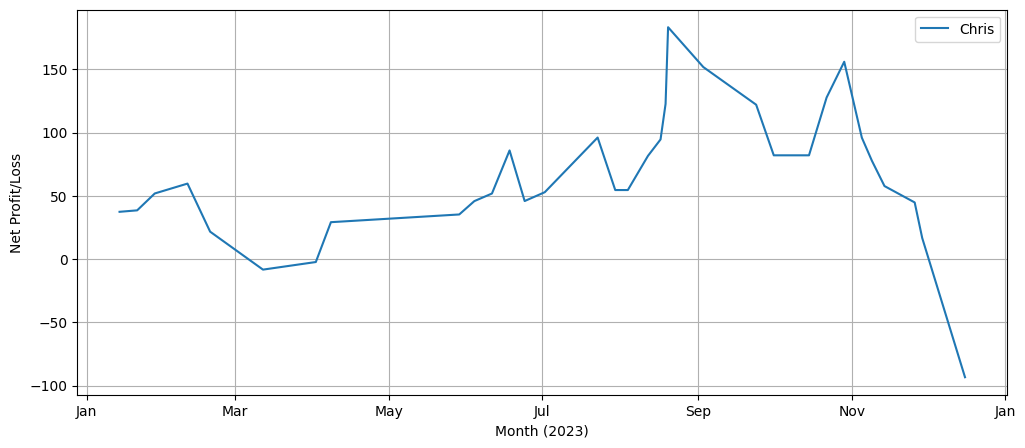

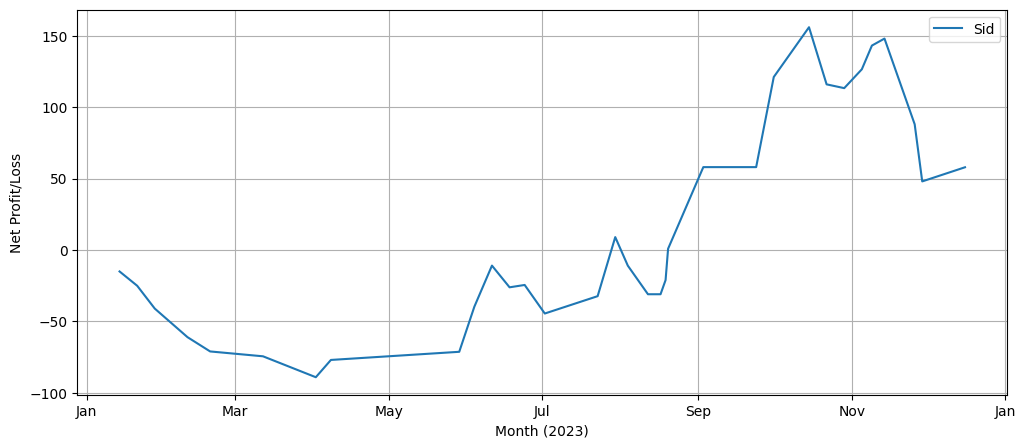

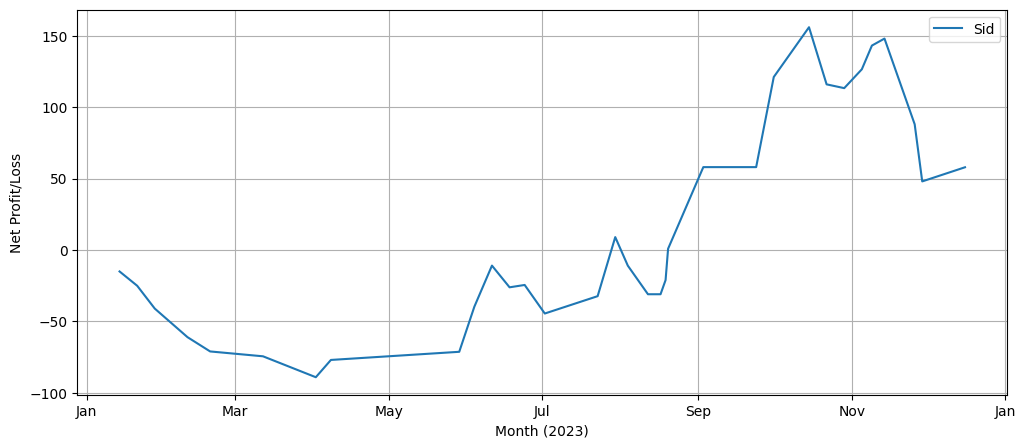

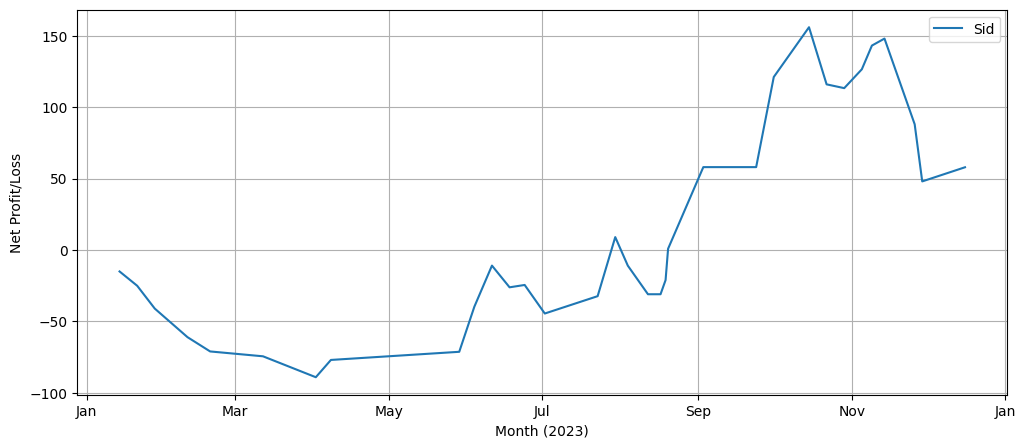

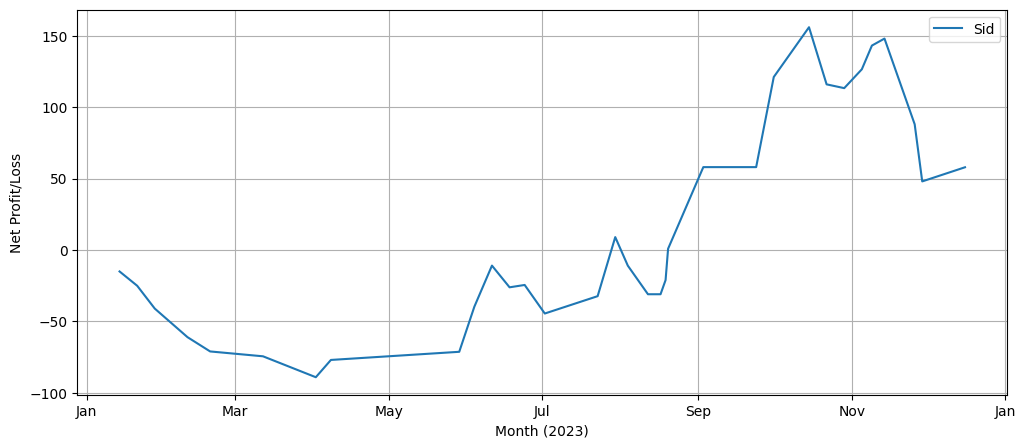

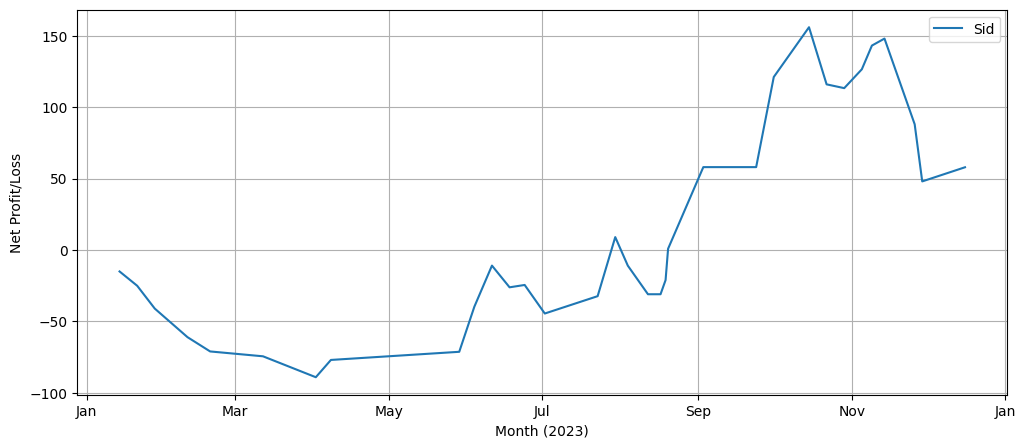

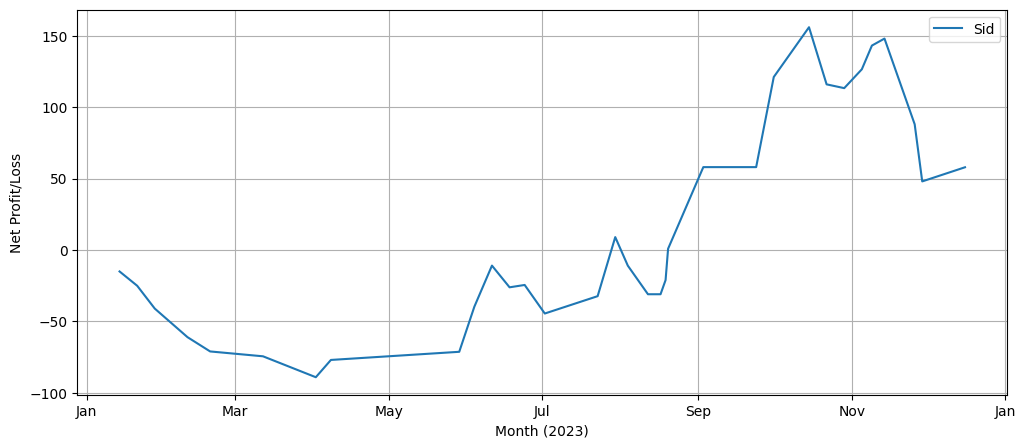

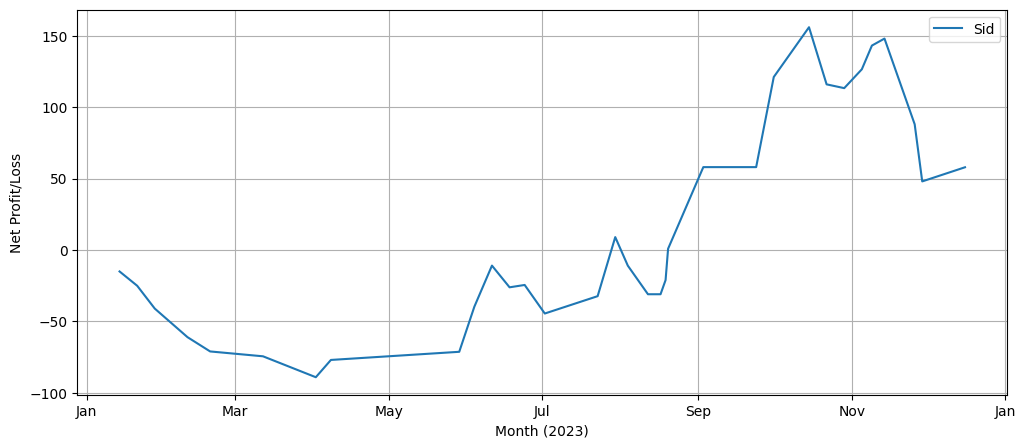

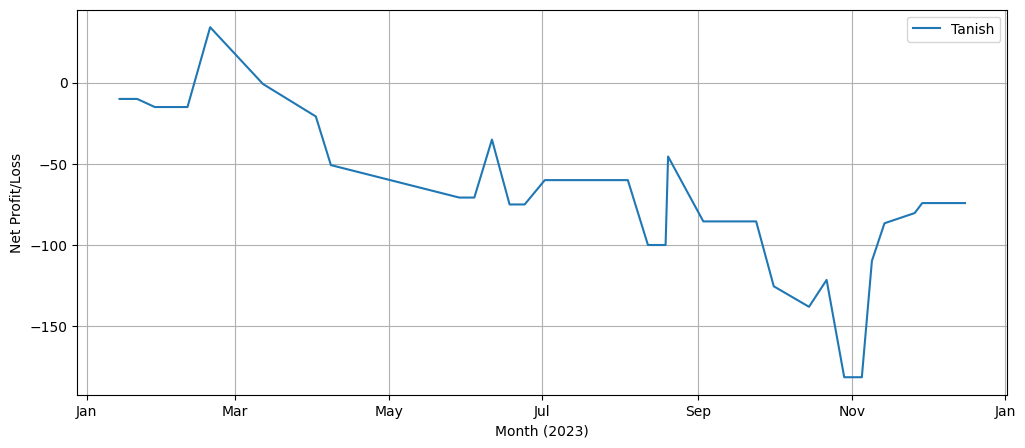

In [30]:
import pandas as pd

import dash
from dash import Dash, dash_table
#import dash_html_components as html
import dash_core_components as dcc
from dash import html
from dash import dcc
from dash.dependencies import Output, Input, State

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
from datetime import date, timedelta
import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [31]:
#%pip freeze > requirements.txt

## Preprocessing

In [32]:
df = pd.read_csv("data.csv")
df.set_index('Unnamed: 0', inplace=True)
df.rename_axis(None, inplace=True) #remove index header

dftime2 = df.iloc[:,2:].T.copy() # to be used for personal form calculation
dftime3 = df.iloc[:,2:].T.copy() # to be used for global form calculation
df.fillna(0, inplace=True)
dftime = df.iloc[:,2:].T.copy()

### Preprocessing for Profit/Loss against time analysis

In [33]:
crit_tables = 6 # plotly graph will only show player who have player at least this number of games
dftime['Guests'] = dftime.T[dftime.T['TABLES'] < crit_tables].sum().to_frame() #sum all guest values for by date
dftime = dftime.T[dftime.T['TABLES'] >= crit_tables].T
#dftime = dftime[['Ashish','Sid','Chris','Panos','Kartik','Tanish','Guests']] #create the new table
dftime.drop(index='TABLES' , inplace= True)
dftime = dftime.rename_axis('Date').reset_index()

# Initialize variables to keep track of cumulative sums for each column
cumulative_sums = {col: 0 for col in dftime.columns[1:]}

# Iterate through the columns and update values so that the datum of the nth row is the sum of all data up to and including row n 
for col in dftime.columns[1:]:
    for index, row in dftime.iterrows():
        cumulative_sums[col] += row[col]
        dftime.at[index, col] = cumulative_sums[col]

# Convert 'Date' column to datetime format
dftime['Date'] = pd.to_datetime(dftime['Date'])

# Format the 'Date' column
dftime['Date'] = dftime['Date'].dt.strftime('%d-%b')

def melt_data(dftime):
    dftime_melt = dftime.melt(id_vars='Date', value_vars=list(dftime.columns[1:])).rename({'variable':'Player','value':'Net Profit/Loss'}, axis='columns') #melt the table and rename the new columns
    dftime_melt['Net Profit/Loss'] = round(dftime_melt['Net Profit/Loss'],2) # round all values to 2 decimal points
    return dftime_melt

## Group Analysis

### Session Results

In [34]:
def make_table(row):
    selected_data = dftime2.iloc[row+1:row + 2].dropna(axis=1).to_dict('records')
    fig = dash_table.DataTable(
        id='results-table',  # Specify the id for the DataTable
        columns=[{'name': col, 'id': col} for col in dftime2.drop(index='TABLES').iloc[row:row + 1].dropna(axis=1).columns],
        data=selected_data,
        style_table={'fontSize': 22},  # Set the font size
    )
    return fig

### Current Profit/Loss 

In [35]:
def Status_bar(player_list):
    data = [round(value, 2) for value in dftime.loc[dftime.index[-1], player_list].tolist()] #get the current p/l from the last row of the dataframe
    
    # Create a DataFrame for the bar chart
    df = pd.DataFrame({'Player': player_list, 'Net Profit/Loss': data})
    
    # Create the bar chart with Plotly Express
    fig = px.bar(df, x='Net Profit/Loss', y='Player', text='Net Profit/Loss', orientation='h')
    
    # Add a title and axis labels
    fig.update_layout(
        title='Net Profit/Loss for Players',
        xaxis_title='Net Profit/Loss',
        yaxis_title='Player',
        xaxis=dict(
            tickformat="%b",
            showgrid=True,
            tickfont = {'size':16},
        ),
        title_x=0.5,
        title_font = {'size':20},
        yaxis=dict(
            tickfont = {'size':16},
        )
    )

    # Show values next to bars
    fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')

    return fig

### Time Lapse Bar Plot

We will use the `px.bar` method from Plotly Express to show the Net profit of all players over time.

In [36]:
def Time_Lapse(player_list):
    dftime_melt = melt_data(dftime)
    dftime_melt = dftime_melt[dftime_melt['Player'].isin(player_list)] #update the dataframe to include only the names selected
    fig = px.bar(dftime_melt,  
                x='Net Profit/Loss', y = "Player", animation_frame="Date", range_x=(-200,200),hover_data=['Net Profit/Loss'],color='Net Profit/Loss', width=2000, height=800, range_color=(-500,200), orientation= 'h')
    fig.update_layout(
        title="Time Lapse of Profit/Loss of every player",
        xaxis_title="Date",
        yaxis_title="Net Profit/Loss",
        xaxis=dict(
            tickformat="%b",
            showgrid=True,
            tickfont = {'size':16},
        ),
        title_x=0.5,
        title_font = {'size':20},
        yaxis=dict(
            tickfont = {'size':16},
        )
    )

    fig.update_traces(textfont_size=12, textangle=0, textposition="outside",overwrite=True, )  
    fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 600
    return fig

### Histogtam of performance

Define the namelist of the players at interest

In [37]:
namelist = dftime.columns[1:-1].to_list()

## Player Analysis

We will display the currect Net Profit and Profit per Game statistics in the same figure using Plotly's gauge chart. With this method we will also be able to show progression of these two values from a specified reference point. For this case, the reference point is the last game played.

In [38]:
def Current_profit_loss(person):
    def get_ppg(person): # find the previous profit per game statistic
        ppg = df.loc[person]['PPG']
        games_played = df.loc[person]['TABLES']
        last_p_l = df.loc[person][-1]
        net = dftime.loc[dftime.index[-1], person]
        (ppg_ref := ppg) if np.isnan(dftime2[person].tail(1).values) else (ppg_ref := (net - last_p_l) / (games_played - 1))
        return round(ppg_ref, 2)
        
    # Create a subplot grid with 1 row and 2 columns
    fig = make_subplots(rows=1, cols=3)

    # Define data for the first gauge chart
    trace1 = (go.Indicator(
        mode = "number+delta",
        value= int(dftime.loc[dftime.index[-1], person]), #Take the last value of the column
        title={'text': "Net Profit/Loss"},
        delta= {'reference': int(dftime.loc[dftime.index[-2], person]), 'increasing': {'color': "RebeccaPurple"}},
        ))

    # Define data for the second gauge chart
    trace2 = (go.Indicator(
        mode = "number+delta",
        value= round(df.loc[person]['PPG'], 2), # ppg as defined by the first table
        title={'text': "Profit per Game"},
        delta= {'reference': get_ppg(person), 'increasing': {'color': "RebeccaPurple"}},
        ))

    # Define data for the second gauge chart
    trace3 = (go.Indicator(
        mode = "number",
        value= int(df.loc[person]['TABLES']), # ppg as defined by the first table
        title={'text': "Games Played"}
        ))

    fig.update_layout(paper_bgcolor = "lavender", font = {'color': "darkblue", 'family': "Arial"})

    fig = make_subplots(
        rows=1,
        cols=3,
        specs=[[{'type' : 'indicator'}, {'type' : 'indicator'}, {'type': 'indicator'}]],
        )

    fig.append_trace(trace1, row=1, col=1)
    fig.append_trace(trace2, row=1, col=2)
    fig.append_trace(trace3, row=1, col=3)

    return fig

### Session Progress Plot

For this section I originally had a regplot from seaborn. Unfortunatel though after multiple attempts, I couldn't convert the seaborn plot to a plotly graph which is compatible with dash. 

For that reason, I used the scikit-learn library to calculate the best fit curve on the data. I used a pipeline to experiment with the degree that appears to best fit the data. If more and better data were available, a better approach would be to itterate multiple degrees of polynomials and then use the AIC score (Akaike Information Criterion), which is a statistical measure used for model selection, to find select the best polynomial. The best polynomial would be the one with the lowest AIC score.

The AIC is given by:  $\displaystyle{AIC}= 2{k} - 2{ln}\left( {L}\right)$

where $\displaystyle{k}$ is the number of estimated parameters and $\displaystyle{ln}\left( {L}\right)$ is the log of the likelyhood function.

In [39]:
def Progress_Session(person):
    x_data = np.arange(1, len(dftime[person]) + 1)

    fig = px.line() #initialise figure

    #Add the actual data line
    act_line = go.Scatter(x=x_data, y=dftime[person], mode='lines', name='Actual', line=dict(color='blue'))
    fig.add_trace(act_line)

    #make a pipeline that first transforms the data to match a polynomial of n degree and then fits them using linear regression
    pipeline = Pipeline([
        ('poly_features', PolynomialFeatures(degree=3)),
        ('linear_regression', LinearRegression())])

    pipeline.fit(np.array(x_data).reshape(-1, 1), dftime[person]) #fit the data
    Y_pred = pipeline.predict(np.array(x_data).reshape(-1, 1)) #predict the values

    #Add the predicted data line
    trendline = go.Scatter(x=x_data, y=Y_pred, mode='lines', name='Trendline', line=dict(color='red'))
    fig.add_trace(trendline)

    fig.update_layout(
        title='Session Progress',
        xaxis_title='Session Number',
        yaxis_title='Net Profit/Loss',
        xaxis=dict(
            tickformat="%b",
            showgrid=True,
            tickfont = {'size':16},
        ),
        title_x=0.5,
        title_font = {'size':20},
        yaxis=dict(
            tickfont = {'size':16},
        )
    )
    return fig

### Monthly Progress Plot

In [40]:
def Progress_Monthly(person):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(pd.to_datetime(dftime['Date'] + f"-{2023}", format='%d-%b-%Y'), dftime[person], label=person)
    ax.set_ylabel('Net Profit/Loss')
    ax.set_xlabel('Month (2023)')
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%b"))
    ax.legend()
    ax.grid()
    
    # Convert Matplotlib figure to Plotly figure
    x = pd.to_datetime(dftime['Date'] + f"-{2023}", format='%d-%b-%Y')
    y = dftime[person]
    fig = go.Figure(data=[go.Scatter(x=x, y=y)])

    # Customize the layout, including the title
    fig.update_layout(
        title=' Monthly Progress',  # Set your desired title here
        xaxis_title='Month (2023)',
        yaxis_title='Net Profit/Loss',
        xaxis=dict(
            tickformat="%b",
            showgrid=True,
            tickfont = {'size':16},
        ),
        title_x=0.5,
        title_font = {'size':20},
        yaxis=dict(
            tickfont = {'size':16},
        )
    )

    return fig

### Personal and Global Form Preprocessing

In [41]:
def Form_Preprocessing(person, dftime2, dftime3):
    # Personal Form
    dftime5 = dftime2[person].dropna()
    dftime5.drop(index='TABLES' , inplace= True) 
    n = 5
    dftime5 = pd.Series([sum(dftime5[i:i+n]) for i in range(0, len(dftime5)-n+1, 1)]) # sum 3 in a row together
    x = np.array(dftime5).reshape(-1,1) #reshape to fit transform
    filtered_data = StandardScaler().fit_transform(x) #normalise first 
    filtered_data = MinMaxScaler().fit_transform(filtered_data)*10 #convert normalised data into min, max
    filtered_data = [np.round(datum * 10) / 10 for datum in filtered_data]

    # Global Form
    # normalise the performance of all players in the playerlist based on the performance of these people:
    dftime3 = dftime3[dftime3.columns[dftime3.columns.isin(['Ashish', 'Sid', 'Panos', 'Chris', 'Kartik', 'Tanish'])]] 
    if 'TABLES' in dftime3.index:  
        dftime3.drop(index='TABLES' , inplace= True) #drop row with the number of tables
    person_column = dftime3.pop(person)
    dftime3[person] = person_column
    global_list = []
    for column in dftime3:
        dftime4 = dftime3[column].dropna() #drop all NaN values
        global_list.extend(pd.Series([sum(dftime4[i:i+3]) for i in range(0, len(dftime4)-2, 1)])) # sum 3 in a row together
    filtered_data2 = StandardScaler().fit_transform(np.array(global_list).reshape(-1, 1)) #normalise first 
    filtered_data2 = MinMaxScaler().fit_transform(filtered_data2)*10 #convert normalised data into min, max
    filtered_data2 = [np.round(datum * 10) / 10 for datum in filtered_data2]
    
    return filtered_data, filtered_data2
# peronal form data, global form data

### Personal and Global Form Gauge charts

In [42]:
def Gauge_Charts(person):
    filtered_data, filtered_data2 = Form_Preprocessing(person, dftime2, dftime3)
    
    # Create a subplot grid with 1 row and 2 columns
    fig = make_subplots(rows=1, cols=2)

    # Define data for the first gauge chart
    trace1 = (go.Indicator(
        mode = "gauge+number+delta",
        value = float(filtered_data[-1]),
        domain = {'x': [0, 1], 'y': [0, 1]},
        title = {'text': "{} Personal Form".format(person), 'font': {'size': 20}},
        delta = {'reference': int(filtered_data[-2]), 'increasing': {'color': "RebeccaPurple"}},
        gauge = {
            'axis': {'range': [None, 10], 'tickwidth': 1, 'tickcolor': "darkblue"},
            'bar': {'color': "darkblue"},
            'bgcolor': "white",
            'borderwidth': 2,
            'bordercolor': "gray",
            'steps': [
                {'range': [0, 5], 'color': 'red'},
                {'range': [5, 10], 'color': 'cyan'}],
            }))

    # Define data for the second gauge chart
    trace2 = (go.Indicator(
        mode = "gauge+number+delta",
        value = float(filtered_data2[-1]),
        domain = {'x': [0, 1], 'y': [0, 1]},
        title = {'text': "{} Global Form".format(person), 'font': {'size': 20}},
        delta = {'reference': int(filtered_data2[-2]), 'increasing': {'color': "RebeccaPurple"}},
        gauge = {
            'axis': {'range': [None, 10], 'tickwidth': 1, 'tickcolor': "darkblue"},
            'bar': {'color': "darkblue"},
            'bgcolor': "white",
            'borderwidth': 2,
            'bordercolor': "gray",
            'steps': [
                {'range': [0, 5], 'color': 'red'},
                {'range': [5, 10], 'color': 'cyan'}],
            }))

    fig.update_layout(
        paper_bgcolor = "lavender",
        font = {'color': "darkblue", 'family': "Arial"})
    fig = make_subplots(
        rows=1,
        cols=2,
        specs=[[{'type' : 'indicator'}, {'type' : 'indicator'}]],
        )

    fig.append_trace(trace1, row=1, col=1)
    fig.append_trace(trace2, row=1, col=2)

    return fig

# Dash Board

In [44]:
from flask import Flask

In [ ]:
server = Flask(__name__)

app = dash.Dash(__name__, server=server)
app.config.suppress_callback_exceptions = True

# Define the layout of the dashboard
app.layout = html.Div([
    dcc.Tabs(id="tabs", value='personal', children=[
        dcc.Tab(label='Personal Data', value='personal'),
        dcc.Tab(label='Table Data', value='global'),
    ]),
    html.Div(id='page-content'),
])

# Callback to switch between subpages
@app.callback(Output('page-content', 'children'), Input('tabs', 'value'))
def render_content(tab):
    if tab == 'personal': #break into tabs
        return html.Div([
            dcc.Dropdown( #make a dropdown section for the person at interrest
                id='Player',
                options=[{'label': person, 'value': person} for person in namelist],
                value=namelist[1]  # Set the default value
               ),
            html.Div(id='current-profit'),
            html.Div(id='session-progress'),       
            html.Div(id='monthly-progress'), # Container for the monthly personal data
            html.Div(id='gauge-chart'), # Container for the gauge charts
        ])
    elif tab == 'global':
        return html.Div([
            dcc.Dropdown(
                id='row-dropdown',
                options=[{'label': '{1} - Session {0}'.format(i+1, dftime2.index[1+i].strftime('%d-%b')), 'value': i} for i in range(dftime2.shape[0]-1)],
                value= dftime2.shape[0]-2,  # Default to the last game
                style={'width': '50%'}
            ),
            html.Div(id='results-table-container', style={'margin-bottom': '50px'}),  # Change id to 'results-table-container'
            dcc.Checklist(
                id='Name-Checklist',
                options=[{'label': person, 'value': person} for person in namelist],
                value=namelist[:5], # select the first 5 people from the namelist
                labelStyle={'font-size': '24px',},  # Increase font size and center labels
                inline=True,
            ),
            html.Div(id='bar-plot'),
            html.Div(id='time-lapse'),
        ])
    
# Callback to update the current profit/loss value
@app.callback(Output('current-profit', 'children'), Input('Player', 'value'))
def update_current_profit_loss_value(selected_person):
    fig = Current_profit_loss(selected_person)
    return dcc.Graph(figure=fig)

# Callback to update the progress per session chart based on the selected person    
@app.callback(Output('session-progress', 'children'), Input('Player', 'value'))
def update_progress_session_chart(selected_person):
    fig = Progress_Session(selected_person)
    return dcc.Graph(figure=fig)

# Callback to update the monthly progress chart based on the selected person    
@app.callback(Output('monthly-progress', 'children'), Input('Player', 'value'))
def update_progress_montly_chart(selected_person):
    fig = Progress_Monthly(selected_person)
    return dcc.Graph(figure=fig)

# Callback to update the gauge charts based on the selected person  
@app.callback(Output('gauge-chart', 'children'), Input('Player', 'value'))
def update_gauge_charts(selected_person):
    fig = Gauge_Charts(selected_person)
    return dcc.Graph(figure=fig)

# Callback to update the table based on the selected row
@app.callback(Output('results-table-container', 'children'), Input('row-dropdown', 'value'))
def update_table(selected_row):
    fig = make_table(selected_row)
    return fig

# Callback to update the current progress bar chart based on the selected people (from the checklist)
@app.callback(Output('bar-plot', 'children'), Input('Name-Checklist', 'value'))
def update_graph(selected_people):
    fig = Status_bar(selected_people)
    return dcc.Graph(figure=fig)

# Callback to update the current time lapse bar chart based on the selected people (from the checklist)
@app.callback(Output('time-lapse', 'children'), Input('Name-Checklist', 'value'))
def update_graph(selected_people):
    fig = Time_Lapse(selected_people)
    return dcc.Graph(figure=fig)

if __name__ == '__main__':
    app.run_server(port=8050, threaded=False, debug=False)

C:\Users\PanSt\AppData\Local\Temp\ipykernel_26484\2521024298.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\PanSt\AppData\Local\Temp\ipykernel_26484\2247160583.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PanSt\AppData\Local\Temp\ipykernel_26484\2247160583.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PanSt\AppData\Local\Temp\ipyker